In [1]:
#These are the libraries you can use.  You may add any libraries directy related to threading if this is a direction
#you wish to go (this is not from the course, so it's entirely on you if you wish to use threading).  Any
#further libraries you wish to use you must email me, james@uwaterloo.ca, for permission.

from IPython.display import display, Math, Latex

import pandas as pd
import numpy as np
import numpy_financial as npf
import yfinance as yf
import matplotlib.pyplot as plt
import random
from datetime import datetime

import asyncio
import httpx
from scipy.optimize import minimize
import seaborn as sns

## Group Assignment
### Team Number: 10
### Team Member Names: David, Tanvi, Johan
### Team Strategy Chosen: Market Meet

## Contribution Declaration

The following team members made a meaningful contribution to this assignment:

David, Tanvi, and Johan

-------------------------------------------------------------------------------------------------------------------------------------------
#### Markdown Introduction:

Goal: Try to have the 25-stock portfolio’s returns match the average of the TSX composite + S&P 500’s return (~0.370%) as accurately as possible, over the 5-day period (Nov. 24 to Nov. 28).

- **S&P/TSX Composite Index** (`^GSPTSE`)
- **S&P 500 Index** (`^GSPC`)

| Index | YTD Return | Daily Return (÷ 252)| 5-Day Estimated Return |
|:------|:-----------:|:--------------------:|:----------------------:|
| TSX Composite | 21.74% | 0.0863% | 0.43% |
| S&P 500 | 15.55% | 0.0617% | 0.31% |
| **Average (50/50)** | — | — | **≈ 0.370%** |

Use historical data from `yfinance` to calculate:
  - Mean returns
  - Volatility (standard deviation)
  - Beta and alpha values
  - Correlation with the benchmark
  - Idiosyncratic (residual) risk

Select 10–25 stocks (we aim for 25 if possible) that:
- Have **beta ≈ 1** and high correlation with the benchmark
- Are liquid (average daily volume ≥ 5,000 shares)
- Have sector diversification (no sector >40% of total value)
- Include at least one large-cap (> 10B CAD) and one small-cap (< $2B CAD)

Weights are between (100/(2n))% and 15% (for 25 stocks, between 2% and 15%)
- Spend approximately **$1,000,000 CAD**, net of trading fees:
- Fees = min(2.15 USD, 0.001 USD * shares) per trade, applied to all stock purchases
-------------------------------------------------------------------------------------------------------------------------------------------

In [2]:
## === Load Stock Tickers from the TA's CSV File ===

tickers_df = pd.read_csv("Tickers_Example.csv", header=None)
tickers_list = tickers_df[0].dropna().astype(str).tolist()

In [3]:
# === 1. Original Setup & Data Download ===

sp500 = "^GSPC"
tsx = "^GSPTSE"
start = "2024-01-01"
end = "2025-9-30"

min_vol = 5_000
corr_min  = 0.20
small_cap = 2_000_000_000
large_cap = 10_000_000_000
earn_low  = datetime(2025, 11, 24).date()
earn_high = datetime(2025, 11, 28).date()

# Download price + volume data
tickers_all = tickers_list + [sp500, tsx]
print("Starting synchronous download of price/volume data...")
data = yf.download(tickers_all, start=start, end=end, auto_adjust=False, progress=False)
close = data["Close"]
vol = data["Volume"]
print("Price/Volume download complete.")

# Benchmark calculation
bench = ((close[sp500] + close[tsx]) / 2).dropna()
bench_ret = bench.pct_change().dropna()
stocks = close[tickers_list].loc[bench_ret.index].dropna(how="all", axis=1)
rets = stocks.pct_change().dropna()

# FX rate (Keep synchronous as it's a single, fast call)
fx_raw = yf.Ticker("CADUSD=X").history(period="1d")["Close"]
usd_to_cad = fx_raw.iloc[-1] if len(fx_raw) > 0 else 0.73  # fallback rate

async def async_get_meta(ticker):
    """Asynchronously fetches metadata for a single ticker."""
    t = ticker
    try:
        ticker_obj = yf.Ticker(t)
        
        # 1. Retrieve stock info
        # Use a try/except for info specifically to avoid crashing the whole ticker
        try:
            info = await asyncio.to_thread(lambda: ticker_obj.info)
        except:
            info = {}
            
        sector = info.get("sector")
        industry = info.get("industry")
        mc_raw = info.get("marketCap", np.nan)
        
        # 2. Market cap. conversion
        if isinstance(mc_raw, (int, float)) and not pd.isna(mc_raw):
            mc = mc_raw if t.endswith(".TO") else mc_raw / usd_to_cad 
        else:
            mc = np.nan

        # Define booleans safely
        small = mc < small_cap if not pd.isna(mc) else False
        large = mc > large_cap if not pd.isna(mc) else False

        # 3. Fetch Earnings Date
        earn = None
        
        # Attempt #1: Calendar (Fast)
        try:
            cal = await asyncio.to_thread(lambda: ticker_obj.calendar)
            if cal and "Earnings Date" in cal:
                dates = cal["Earnings Date"]
                if dates:
                    earn = dates[0]
        except Exception:
            pass 

        # Attempt 2: Full History (Backup)
        if earn is None:
            try:
                e_df = await asyncio.to_thread(lambda: ticker_obj.get_earnings_dates(limit=12))
                if e_df is not None and not e_df.empty:
                    future = [d.date() for d in e_df.index.to_pydatetime() if d.date() >= datetime.now().date()]
                    if future:
                        earn = min(future)
            except Exception:
                pass 

        return {
            "Ticker": t,
            "Sector": sector,
            "Industry": industry,
            "MarketCap": mc,
            "Small-cap": small,  
            "Large-cap": large,  
            "Earnings Date": earn
        }

    except Exception as e:
        # Fallback in case of total code failure
        return {
            "Ticker": t,
            "Sector": np.nan, "Industry": np.nan, "MarketCap": np.nan,
            "Small-cap": False, 
            "Large-cap": False, 
            "Earnings Date": None
        }
    
async def fetch_all_metadata(tickers):
    print("Starting asynchronous metadata fetching with delay...")
    tasks = []
    for i, t in enumerate(tickers):
        # Get the metadata
        task = async_get_meta(t)
        tasks.append(task)

        # Pause execution for a short time every few requests to reduce the risk of timeout
        if i > 0 and i % 5 == 0: # Example: pause every 5 tickers
            await asyncio.sleep(0.25) 

    results = await asyncio.gather(*tasks)
    print("Metadata retrieval complete.")
    return results

metadata_results = await fetch_all_metadata(stocks.columns)

# Convert results to DataFrame
meta = pd.DataFrame(metadata_results).set_index("Ticker")
meta = meta.loc[stocks.columns] # Re-align index order
meta["Small-cap"] = meta["Small-cap"].astype(bool)
meta["Large-cap"] = meta["Large-cap"].astype(bool)

# Helper functions
def avg_volume(series):
    """Average daily volume after removing months with <18 trading days."""
    s = series.dropna()
    if s.empty: return np.nan
    month = s.index.to_period("M")
    valid = month.value_counts()[lambda x: x >= 18].index
    return s[month.isin(valid)].mean()

def weekly_vol(r):
    """Weekly volatility computed from daily returns."""
    w = (1 + r).resample("W-FRI").prod() - 1
    w = w.dropna()
    return w.std() if not w.empty else np.nan

Starting synchronous download of price/volume data...



4 Failed downloads:
['MON', 'CELG', 'RTN', 'AGN']: YFTzMissingError('possibly delisted; no timezone found')


Price/Volume download complete.
Starting asynchronous metadata fetching with delay...
Metadata retrieval complete.


In [4]:
# === 2. Calculate the Stock & Benchmark Metrics ===

metrics = pd.DataFrame(index=stocks.columns,
                       columns=["AvgVol", "StdDev (%)", "Covariance", "Beta", "Correlation", "WeeklyVol %","IdioVol %"],
                       dtype=float)

for t in stocks.columns:
    r = rets[t].dropna()
    b = bench_ret.reindex(r.index).dropna()

    # Align the indexes
    idx = r.index.intersection(b.index)
    r = r.loc[idx]
    b = b.loc[idx]

    # Compute each of the metrics via their formulas
    av = avg_volume(vol[t].loc[start:end])
    sd = r.std() * 100
    cv = r.cov(b) * (100**2)
    beta = cv / (b.var() * (100**2)) if b.var() > 0 else np.nan
    corr = r.corr(b)
    wv = weekly_vol(r) * 100

# --- NEW CALCULATION: Idiosyncratic Volatility ---
# Formula: Std Dev of (Actual Return - Expected Return)
# Expected Return = Alpha + (Beta * Benchmark Return)
    if not np.isnan(beta):
        # Calculate Alpha
        alpha = r.mean() - beta * b.mean()
        
        # Calculate the residual value (not explained by the benchmark)
        residuals = r - (alpha + beta * b)
        
        # Calculate idiosyncratic volatility (Std Dev of residuals)
        iv = residuals.std() * 100
    else:
        iv = np.nan

    metrics.loc[t] = [av, sd, cv, beta, corr, wv, iv]

# --- Apply assignment filters & requirements ---

keep_vol = metrics["AvgVol"] >= min_vol
keep_corr = metrics["Correlation"] >= corr_min

keep_earn = pd.Series(True, index=metrics.index)
for t in metrics.index:
    e = meta.loc[t, "Earnings Date"]
    if meta.loc[t, "Small-cap"] and isinstance(e, datetime):
        if earn_low <= e <= earn_high:
            keep_earn[t] = False

mask = keep_vol & keep_corr & keep_earn

filtered = metrics[mask].join(meta, how="left")
filtered_tickers = list(filtered.index)

print("# of Original Stocks:", len(tickers_list))
print("# of Filtered Stocks:", len(filtered_tickers))
display(filtered.head(len(filtered_tickers)))

# --- Reference data for the benchmark ---

bench_std = bench_ret.std() * 100
bench_week = weekly_vol(bench_ret) * 100

print("Benchmark Std Dev:", bench_std)
print("Benchmark Volatility:", bench_week)

# of Original Stocks: 42
# of Filtered Stocks: 27


,AvgVol,StdDev (%),Covariance,Beta,Correlation,WeeklyVol %,IdioVol %,Sector,Industry,MarketCap,Small-cap,Large-cap,Earnings Date
Ticker,,,,,,,,,,,,,
AAPL,5.720343e+07,1.874138,0.852491,1.318346,0.565663,3.987233,1.545482,Technology,Consumer Electronics,5.679706e+12,False,True,2026-01-29
ABBV,5.935053e+06,1.582680,0.313977,0.485553,0.246703,3.690119,1.533761,Healthcare,Drug Manufacturers - General,5.886874e+11,False,True,2025-10-31
ABT,6.020370e+06,1.303263,0.239018,0.369632,0.228070,2.682354,1.268915,Healthcare,Medical Devices,3.143211e+11,False,True,2026-01-21
ACN,3.158951e+06,1.683341,0.580339,0.897473,0.428726,3.605794,1.520788,Technology,Information Technology Services,2.211332e+11,False,True,2025-12-18
AIG,4.314382e+06,1.395919,0.588438,0.909997,0.524216,2.680547,1.188744,Financial Services,Insurance - Diversified,5.932318e+10,False,True,2025-11-04
AMZN,4.233414e+07,1.989823,0.974934,1.507698,0.609299,3.882665,1.577811,Consumer Cyclical,Internet Retail,3.325798e+12,False,True,2025-10-30
AXP,2.862413e+06,1.792977,1.016271,1.571624,0.704862,3.628533,1.271837,Financial Services,Credit Services,3.461799e+11,False,True,2026-01-23
BA,8.903128e+06,2.305566,0.894239,1.382906,0.482331,5.268077,2.019650,Industrials,Aerospace & Defense,1.925497e+11,False,True,2026-01-28
BAC,3.932023e+07,1.615074,0.827402,1.279546,0.637080,3.648955,1.244896,Financial Services,Banks - Diversified,5.383676e+11,False,True,2026-01-14


Benchmark Std Dev: 0.8034836577141855
Benchmark Volatility: 1.48885560758792


In [5]:
## === 3. Historical Stock Returns vs TSX/S&P 500 Benchmark ===

periods = [5, 21, 63, 252]

# Prices aligned with the benchmark dates
px = stocks[filtered_tickers].loc[stocks.index.intersection(bench.index)].dropna(how="all", axis=1)

def trailing_ret(series, d):
    s = series.dropna()
    if len(s) <= 1: return np.nan
    if len(s) <= d: return (s.iloc[-1] / s.iloc[0] - 1) * 100
    return (s.iloc[-1] / s.iloc[-(d+1)] - 1) * 100

def calc_avg_weekly(series):
    """Calculates the mean weekly return (%) over the available period."""
    # Resample to weekly (Friday close)
    w_prices = series.dropna().resample("W-FRI").last()
    # Calculate % change
    w_rets = w_prices.pct_change().dropna()
    return w_rets.mean() * 100

# Add "Avg Weekly (%)" returns to the column list
stock_returns = pd.DataFrame(index=px.columns,
                             columns=[f"{d}d" for d in periods] + ["Avg Weekly (%)"])

for t in px.columns:
    for d in periods:
        stock_returns.loc[t, f"{d}d"] = trailing_ret(px[t], d)
    
    # Calculate and store the average weekly return for the stock
    stock_returns.loc[t, "Avg Weekly (%)"] = calc_avg_weekly(px[t])

# Returns table for the benchmark
bench_returns = pd.DataFrame(index=[f"{d}d" for d in periods],
                             columns=["TSX/S&P Benchmark (%)"])

for d in periods:
    bench_returns.loc[f"{d}d"] = trailing_ret(bench, d)

bench_returns.loc["Avg Weekly (%)"] = calc_avg_weekly(bench)

# Formatting (round to 2 decimal places)
stock_returns = stock_returns.astype(float).round(2)
bench_returns = bench_returns.astype(float).round(2)

display(stock_returns)
display(bench_returns)

,5d,21d,63d,252d,Avg Weekly (%)
Ticker,,,,,
AAPL,-0.64,9.40,26.58,15.29,0.45
ABBV,0.26,7.33,19.47,15.66,0.42
ABT,-2.57,1.32,-0.42,15.87,0.24
ACN,2.92,-3.58,-16.58,-26.53,-0.27
AIG,1.79,-4.53,-8.32,6.28,0.17
AMZN,-2.40,-4.07,2.33,19.17,0.54
AXP,0.39,4.69,9.92,30.56,0.72
BA,2.35,-8.08,7.16,39.95,-0.01
BAC,0.96,3.82,10.45,32.31,0.53


,TSX/S&P Benchmark (%)
5d,-0.05
21d,4.86
63d,11.37
252d,25.41
Avg Weekly (%),0.40


In [6]:
# === 4. Scoring & Normalization ===

# 1. Merge Dataframes
# We need 'Avg Weekly (%)' from stock_returns combined with Beta/Idio/Cap from filtered
df_score = filtered.join(stock_returns["Avg Weekly (%)"], how="inner")

# 2. Get the target return for the benchmark
target_return = bench_returns.loc["Avg Weekly (%)", "TSX/S&P Benchmark (%)"]
print(f"Target Benchmark Weekly Return: {target_return}%")

# A. Beta Score (40%)
# Logic: Minimize the difference (gap) between each Stock's Beta and 1.0
df_score["Beta_Gap"] = (df_score["Beta"] - 1.0).abs()
# Rank: Ascending = False, means the Smallest Gap gets the Highest Score
df_score["Rank_Beta"] = df_score["Beta_Gap"].rank(ascending=False)

# B. Return Score (20%)
# Logic: Minimize the distance (gap) between Stock Return and Benchmark Return
df_score["Return_Gap"] = (df_score["Avg Weekly (%)"] - target_return).abs()
# Rank: Ascending = False means the Smallest Gap gets the Highest Score
df_score["Rank_Return"] = df_score["Return_Gap"].rank(ascending=False)

# C. Idiosyncratic Volatility Score (20%)
# Logic: Lower is better
# Rank: Ascending = False means the Lowest Volatility gets the Highest Score
df_score["Rank_Idio"] = df_score["IdioVol %"].rank(ascending=False)

# D. Market Cap Score (20%)
# Logic: Higher is better (liquidity & index drivers)
# Rank: Ascending = True means the Highest Cap gets the Highest Score
df_score["Rank_Cap"] = df_score["MarketCap"].rank(ascending=True)

# Normalize ranks to a 0-100 scale relative to the number of stocks
n_stocks = len(df_score)

# Weights: Beta = 4, Others = 2 (Total = 10 parts)
# Formula: (4*Beta + 2*Cap + 2*Return + 2*Idio) / 10
df_score["Final_Score"] = (
    (0.40 * df_score["Rank_Beta"]) +
    (0.20 * df_score["Rank_Return"]) +
    (0.20 * df_score["Rank_Idio"]) +
    (0.20 * df_score["Rank_Cap"])
)

# Sort by the Final Score
df_final = df_score.sort_values("Final_Score", ascending=False)

# --- Selection & Constraints ---

# 1. Initial Attempt: Pick Top 25 Stocks
top_25 = df_final.head(25).copy() 

# 2. Check if there is a Small Cap
has_small = top_25["Small-cap"].any()

if not has_small:
    #No Small Cap in Top 25. So, we swap the lowest-ranked large cap with the best-scoring small cap
    
    # Identify candidates: Stocks NOT in the top 25 that are small caps
    # We use iloc[25:] to look at stocks ranked 26th and below
    remaining_stocks = df_final.iloc[25:]
    
    small_cap_candidates = remaining_stocks[remaining_stocks["Small-cap"] == True]
    
    if not small_cap_candidates.empty:
        # A. Find the best available small cap (i.e. the first one, since df_final is sorted)
        best_small_cap = small_cap_candidates.iloc[[0]]
        
        # B. Drop the lowest-ranked stock from our top 25 list (i.e. the last one)
        top_25 = top_25.iloc[:-1]
        
        # C. Add the best small cap
        top_25 = pd.concat([top_25, best_small_cap])
        
        print(f"Replaced rank 25 with Small Cap '{best_small_cap.index[0]}'.")

# 3. Finalized formatting
cols_to_show = ["Beta", "Beta_Gap", "Avg Weekly (%)", "Return_Gap", "IdioVol %", "MarketCap", "Final_Score", "Small-cap"]

display(top_25[cols_to_show])

print(f"# of Stocks: {len(top_25)}")
print(f"Large Cap?: {top_25['Large-cap'].any()}")
print(f"Small Cap?: {top_25['Small-cap'].any()}")

Target Benchmark Weekly Return: 0.4%
Replaced rank 25 with Small Cap 'TLRY'.


,Beta,Beta_Gap,Avg Weekly (%),Return_Gap,IdioVol %,MarketCap,Final_Score,Small-cap
Ticker,,,,,,,,
RY.TO,0.816084,0.183916,0.48,0.08,0.728463,2.981106e+11,22.6,False
BAC,1.279546,0.279546,0.53,0.13,1.244896,5.383676e+11,20.3,False
AAPL,1.318346,0.318346,0.45,0.05,1.545482,5.679706e+12,19.8,False
LLY,0.852891,0.147109,0.32,0.08,2.182702,1.339180e+12,19.4,False
BLK,1.324711,0.324711,0.50,0.10,1.024886,2.219357e+11,18.4,False
AIG,0.909997,0.090003,0.17,0.23,1.188744,5.932318e+10,18.0,False
UNP,0.864739,0.135261,0.02,0.38,1.163594,1.891604e+11,17.6,False
BK,1.111586,0.111586,0.86,0.46,1.004612,1.058104e+11,17.4,False
TD.TO,0.603777,0.396223,0.31,0.09,1.007806,1.991012e+11,16.9,False


# of Stocks: 25
Large Cap?: True
Small Cap?: True


In [7]:
# === 5. Portfolio Optimization ===

def optimize_weights_for_top25(rets, stock_returns, bench_returns, top25, meta, df_score, lam=0.01):

    # get list of the selected tickers
    tickers = list(top25.index)

    # get final score values for these tickers
    score_vec = df_score.loc[tickers, "Final_Score"].astype(float)

    # normalize scores so they sum to one
    score_norm = score_vec / score_vec.sum()

    # get each stock's weekly return
    weekly_stock_ret = stock_returns.loc[tickers, "Avg Weekly (%)"].astype(float) / 100

    # get benchmark weekly return
    weekly_bench_ret = float(bench_returns.loc["Avg Weekly (%)", "TSX/S&P Benchmark (%)"]) / 100

    # objective combines strong return matching and score alignment
    def objective(weights):
        #compute portfolio weekly return
        port_ret = np.dot(weights, weekly_stock_ret)

        # we square the difference between portfolio return and benchmark return
        # then multiply by 1,000,000 so that even tiny differences become extremely important to the optimizer
        # which forecs the portfolio return to match the benchmark as close as it can
        track_err = 1_000_000 * (port_ret - weekly_bench_ret)**2

        # the score alignment encourages higher scoring stocks to have higher weights
        score_err = np.sum((weights - score_norm)**2)
        return track_err + lam * score_err

    # weights must sum to one
    def sum_to_one(weights):
        return np.sum(weights) - 1

    # any one sector must not exceed 40%
    def sector_check(weights):
        sector_totals = {}
        for i, t in enumerate(tickers):
            sec = meta.loc[t, "Sector"]
            if sec not in sector_totals:
                sector_totals[sec] = 0
            sector_totals[sec] += weights[i]
        return min(0.40 - w for w in sector_totals.values())

    # ensure at least 1 large cap
    def large_cap_check(weights):
        total = 0
        for i, t in enumerate(tickers):
            if meta.loc[t, "MarketCap"] > 10_000_000_000:
                total += weights[i]
        return total - (1 / len(tickers))

    # ensure at least 1 small cap
    def small_cap_check(weights):
        total = 0
        for i, t in enumerate(tickers):
            if meta.loc[t, "MarketCap"] < 2_000_000_000:
                total += weights[i]
        return total - (1 / len(tickers))

    # list of constraints
    constraints = [
        {'type': 'eq',  'fun': sum_to_one},
        {'type': 'ineq','fun': sector_check},
        {'type': 'ineq','fun': large_cap_check},
        {'type': 'ineq','fun': small_cap_check},
    ]

    # weight bounds from the assignment
    min_weight = 1 / (2 * len(tickers))
    bounds = [(min_weight, 0.15)] * len(tickers)

    # start the near score distribution
    starting_guess = np.array(score_norm)

    # run the portfolio optimizer
    result = minimize(
        fun = objective,
        x0 = starting_guess,
        method = "SLSQP",
        bounds = bounds,
        constraints = constraints,
        options = {"maxiter": 5000, "disp": True}
    )

    # normalize weights
    weights = result.x
    weights = weights / np.sum(weights)

    # compute the final return and difference
    final_port_ret = np.dot(weights, weekly_stock_ret)
    difference = abs(final_port_ret - weekly_bench_ret)

    print("\nOptimization:")
    print("Benchmark Weekly Return:", weekly_bench_ret)
    print("Portfolio Weekly Return:", final_port_ret)
    print("Absolute Difference:", difference)
    print("Sum of Weights:", np.sum(weights))

    return pd.Series(weights, index=tickers)

opt_weights = optimize_weights_for_top25(
    rets = rets,
    stock_returns = stock_returns,
    bench_returns = bench_returns,
    top25 = top_25,
    meta = meta,
    df_score = df_score
)

display(opt_weights)

Optimization terminated successfully    (Exit mode 0)
            Current function value: 7.27267604217457e-05
            Iterations: 10
            Function evaluations: 260
            Gradient evaluations: 10

Optimization:
Benchmark Weekly Return: 0.004
Portfolio Weekly Return: 0.003999906874286688
Absolute Difference: 9.312571331177716e-08
Sum of Weights: 1.0


/opt/anaconda3/lib/python3.13/site-packages/scipy/optimize/_slsqp_py.py:435: RuntimeWarning: Values in x were outside bounds during a minimize step, clipping to bounds
  fx = wrapped_fun(x)
/opt/anaconda3/lib/python3.13/site-packages/scipy/optimize/_slsqp_py.py:439: RuntimeWarning: Values in x were outside bounds during a minimize step, clipping to bounds
  g = append(wrapped_grad(x), 0.0)
/opt/anaconda3/lib/python3.13/site-packages/scipy/optimize/_slsqp_py.py:493: RuntimeWarning: Values in x were outside bounds during a minimize step, clipping to bounds
  a_eq = vstack([con['jac'](x, *con['args'])
/opt/anaconda3/lib/python3.13/site-packages/scipy/optimize/_slsqp_py.py:499: RuntimeWarning: Values in x were outside bounds during a minimize step, clipping to bounds
  a_ieq = vstack([con['jac'](x, *con['args'])


RY.TO    0.053601
BAC      0.051151
AAPL     0.068676
LLY      0.058353
BLK      0.044039
AIG      0.020000
UNP      0.032232
BK       0.071425
TD.TO    0.026557
ABBV     0.058686
ACN      0.020000
CAT      0.073424
AMZN     0.064915
UPS      0.020000
USB      0.020000
ABT      0.036684
AXP      0.044559
PFE      0.020000
C        0.048668
BIIB     0.020000
QCOM     0.034354
TXN      0.027669
BA       0.020000
PYPL     0.020000
TLRY     0.045006
dtype: float64

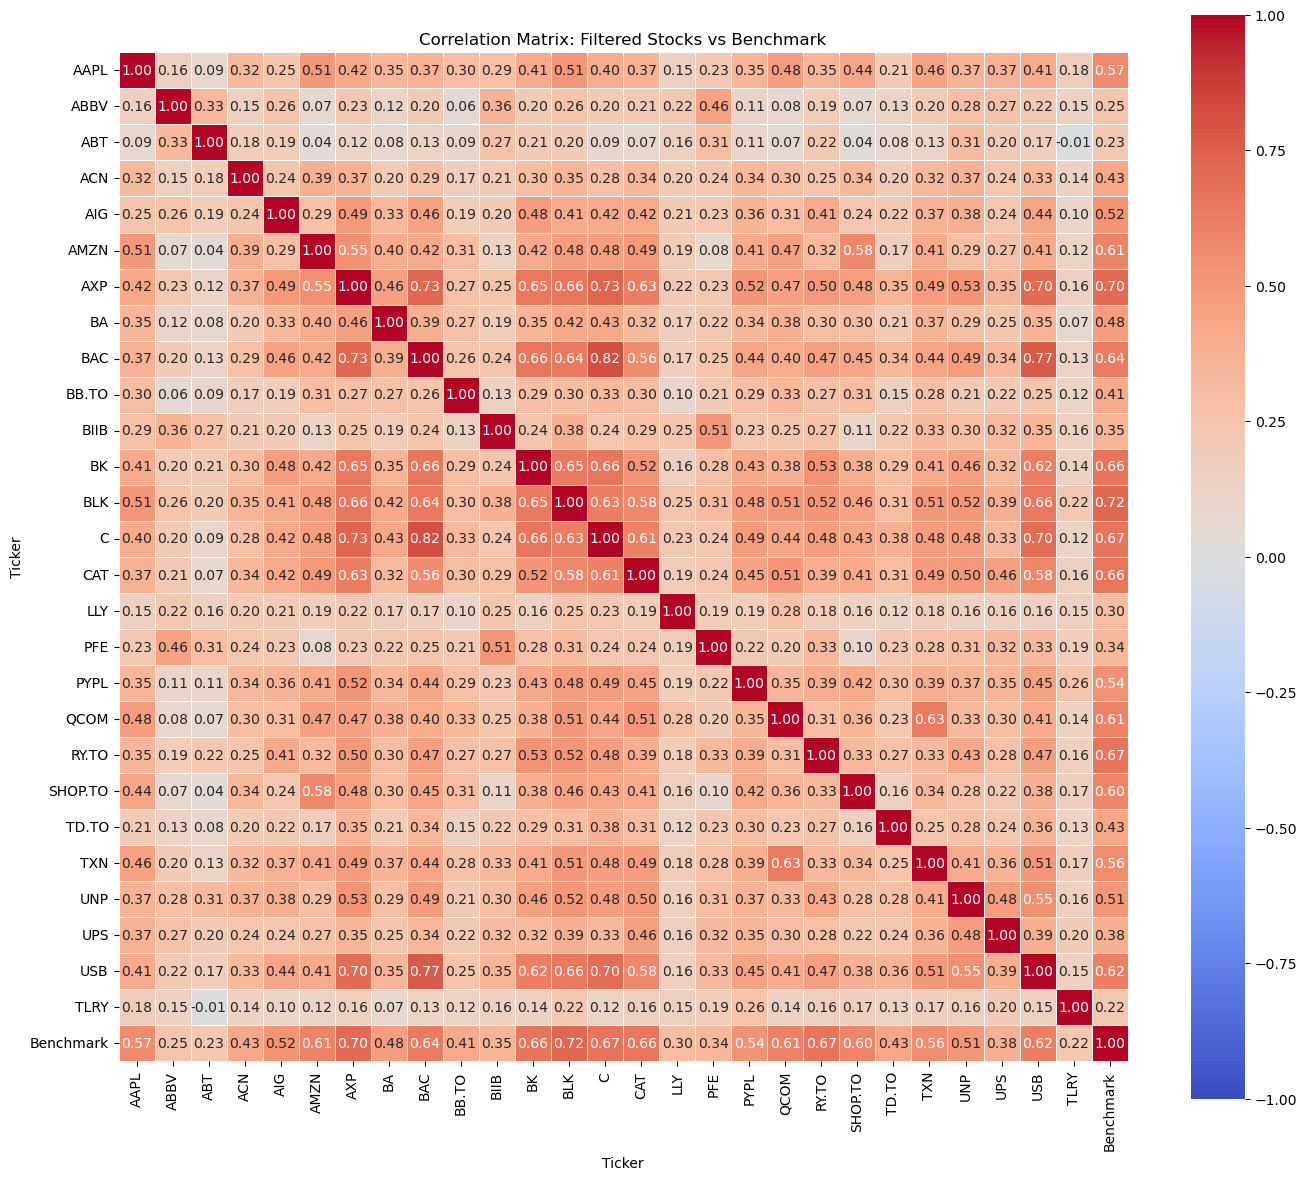

The Correlation heatmap ensures diversification by revealing if stocks are redundant (moving identically) or independent.
It is normalized on a scale of -1 to +1. By removing volatility, it tells us if stocks move in sync.
If two stocks have a high correlation (close to 1), they are mathematically redundant. This information helps diversify a portfolio


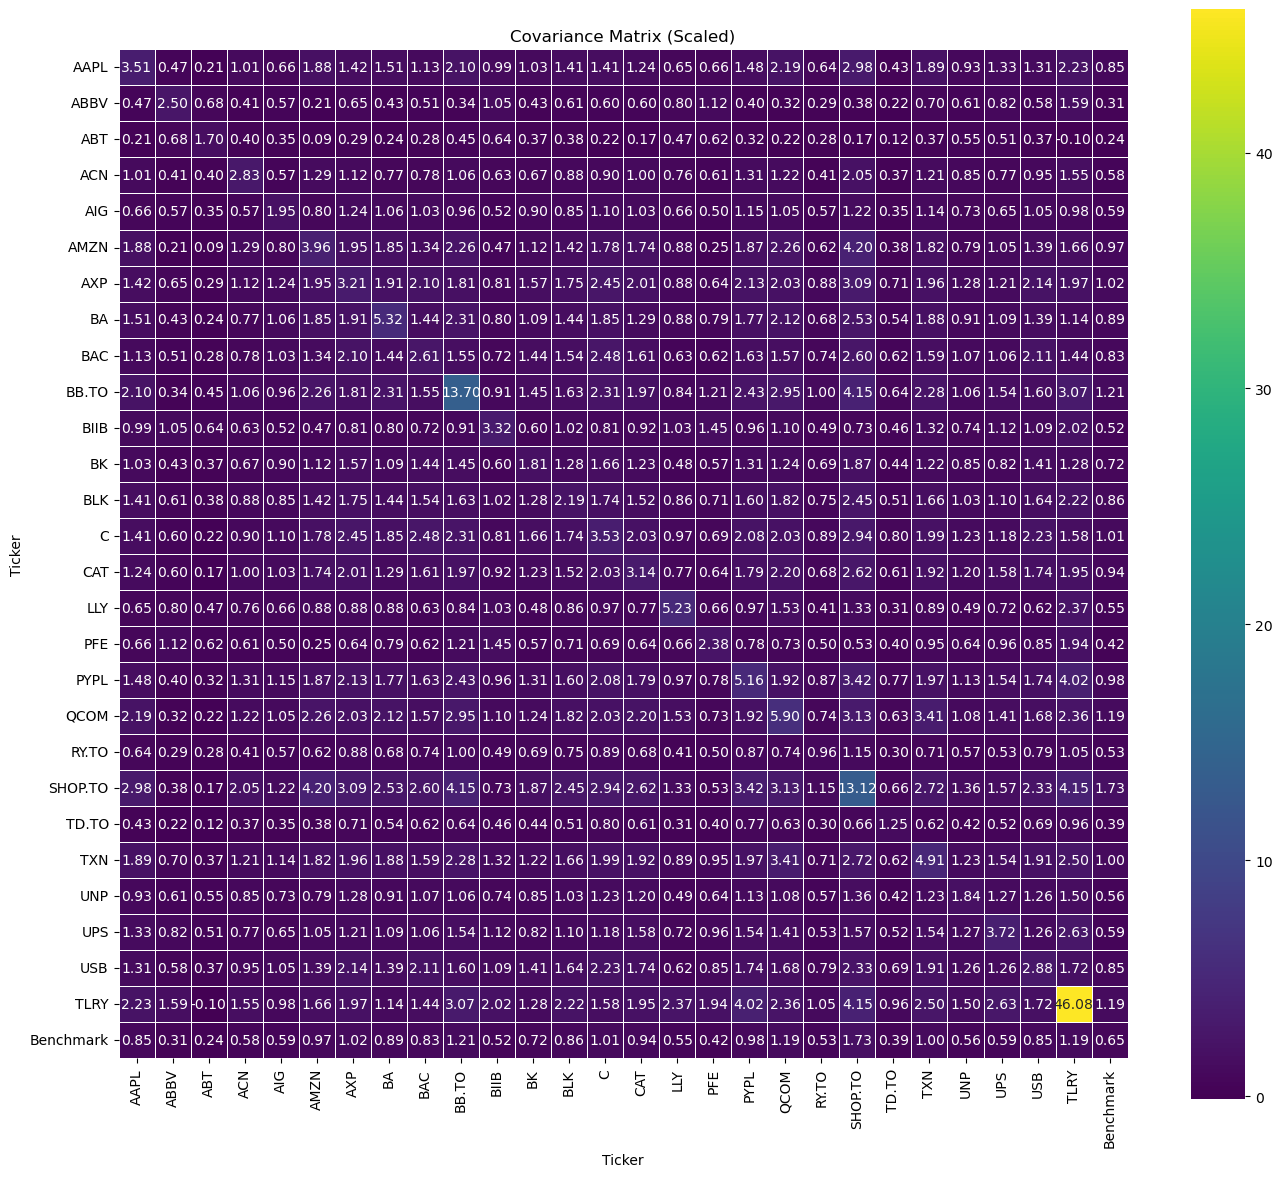

The Covariance heatmap measures actual risk magnitude, identifying how volatile individual stocks are and how much they swing together.
It combines correlation plus volatility, which tells us how much actual risk is being generated.
A high covariance means two stocks not only move together but do so with violent swings


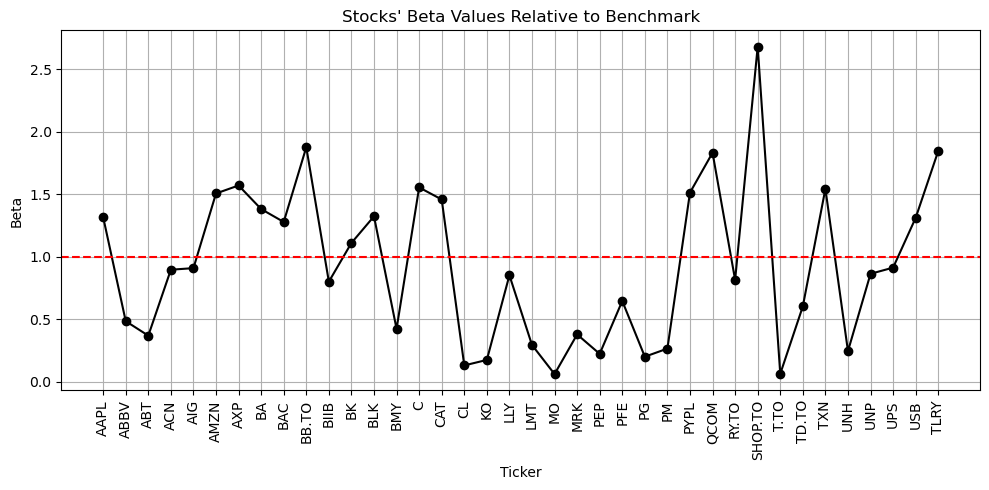

Through the beta chart, we can see a wide range of market sensitivity. While certain stocks sit well above the benchmark beta of 1.00, others fall noticeably below it. The main benefit of this graph is that it showcases the assets' differing market movements, and it helps identify positions that carry higher systematic risk versus those that behave more defensively.

Because these values are spread out, the portfolio ends up holding stocks with different levels of market exposure, and, as a result, the overall risk is dispersed rather than concentrated in one category. This naturally supports diversification across both high-beta and low-beta positions.


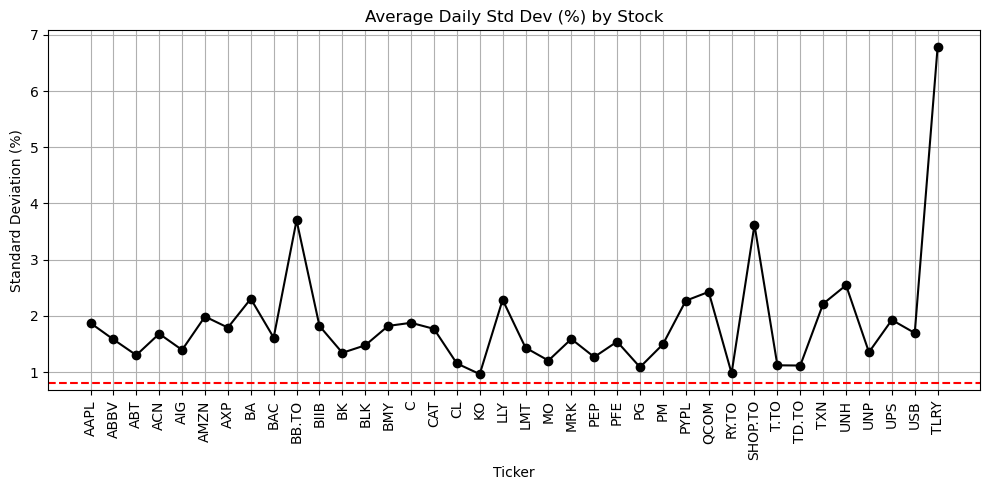

In the standard deviation plot, an important benefit comes from seeing how the overall volatility of each stock compares relative to the rest of the portfolio. As a result, the graph helps us identify which positions contribute to more short-term risk and which ones are more stable. 

Furthermore, by viewing all volatility levels together, the chart makes it easier to understand how spread out the risk is across the holdings. This allows us to judge whether the portfolio relies too heavily on a single volatility profile or whether it gains diversification by balancing varying levels of fluctuation.


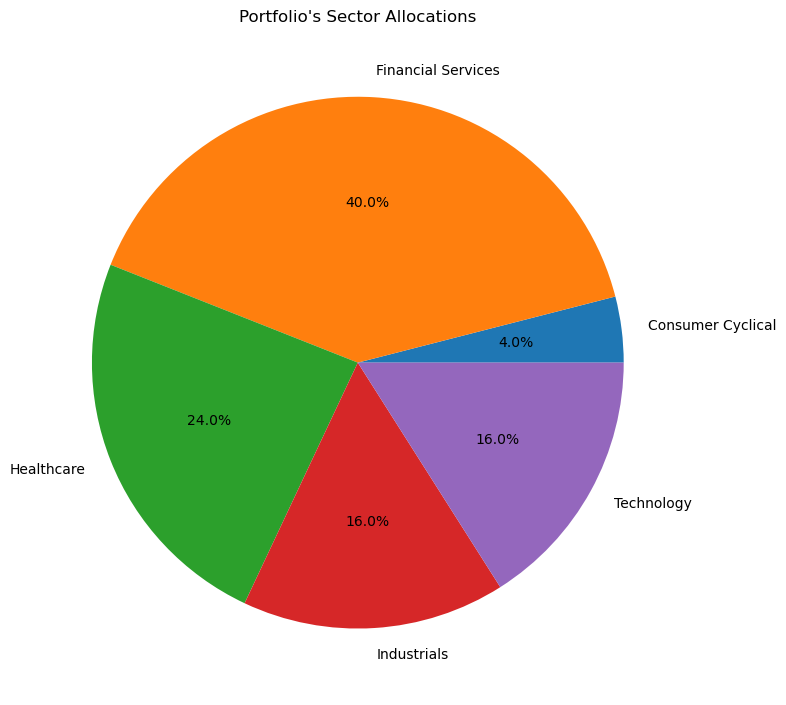

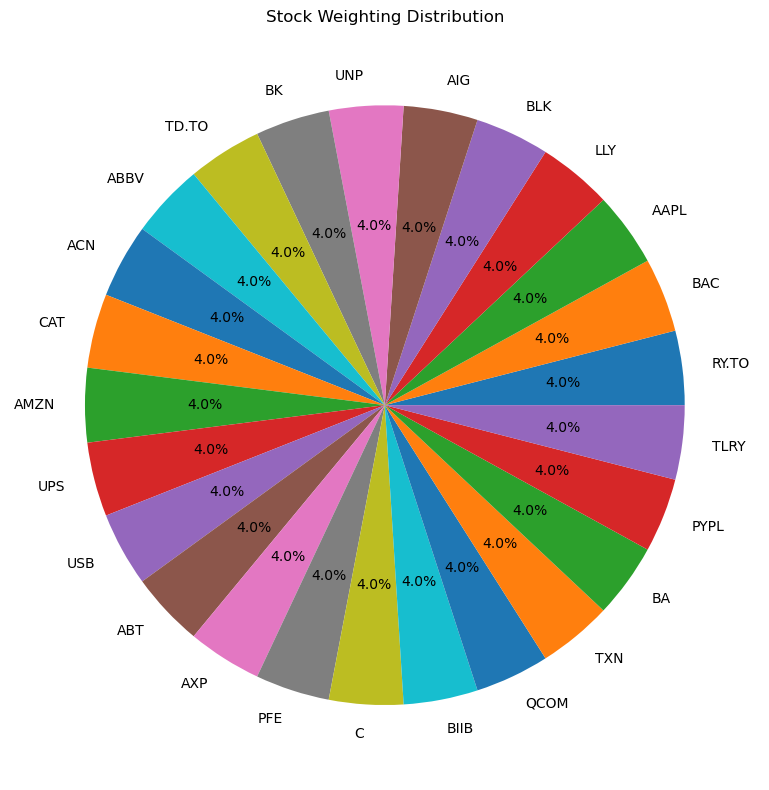

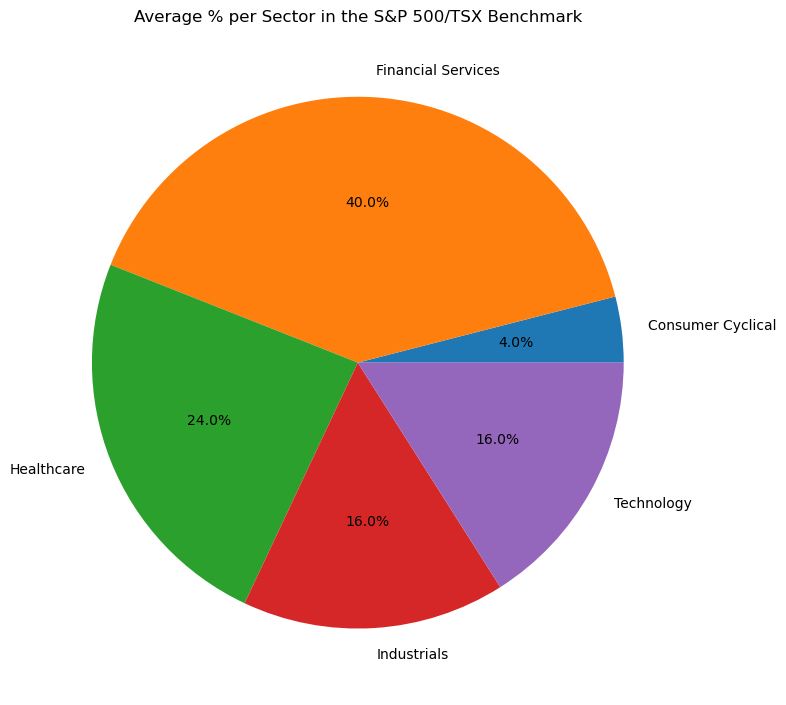

The sector allocation chart focuses on how the portfolio’s value is spread across different industries. By looking at the distribution, we can see which areas the portfolio naturally leans toward and whether any sector carries a noticeably larger share. This makes it easier to understand where the portfolio is most exposed and where diversification is helping reduce concentration risk.

The weight distribution chart focuses on the individual tickers rather than the sectors. It shows how much each position contributes to the whole portfolio, allowing us to confirm that no single stock dominates the allocation. This is especially useful for checking that the final weights line up with the optimization output. The benchmark sector mix is generated using the same set of selected stocks.

Since it shows the underlying composition of the portfolio, it provides a simple reference point to compare against the sector allocation chart. Together, these visuals help clarify both the top-down (sect

In [8]:
# === 6. Visualizing the Data ===

# Temporary placeholder portfolio for Section 6 
# (required because Portfolio_Final is created later in Section 7)
portfolio_df = pd.DataFrame({
    "Ticker": opt_weights.index,
})
portfolio_df["Value (CAD)"] = 1.0
portfolio_df["Weight (%)"] = (1 / len(portfolio_df)) * 100

# =================================
# Correlation & Covariance Heatmaps
# =================================

# 1. Prepare data values
heatmap_data = rets[filtered_tickers].copy()
heatmap_data["Benchmark"] = bench_ret # Add benchmark for comparison

# 2. Compute the matrices
corr_matrix = heatmap_data.corr()
cov_matrix = heatmap_data.cov() * (100**2) # Scale up covariance for readability (like in metrics)

# 3. Plot the Correlation Heatmap
plt.figure(figsize=(14, 12))
sns.heatmap(corr_matrix, annot=True, fmt=".2f", cmap="coolwarm", vmin=-1, vmax=1, square=True, linewidths=0.5)
plt.title("Correlation Matrix: Filtered Stocks vs Benchmark")
plt.tight_layout()
plt.show()

# --- Explanation of Heatmap #1 ---
print("""The Correlation heatmap ensures diversification by revealing if stocks are redundant (moving identically) or independent.
It is normalized on a scale of -1 to +1. By removing volatility, it tells us if stocks move in sync.
If two stocks have a high correlation (close to 1), they are mathematically redundant. This information helps diversify a portfolio""")

# 4. Plot the Covariance Heatmap
plt.figure(figsize=(14, 12))
sns.heatmap(cov_matrix, annot=True, fmt=".2f", cmap="viridis", square=True, linewidths=0.5)
plt.title("Covariance Matrix (Scaled)")
plt.tight_layout()
plt.show()

# --- Explanation of Heatmap #2 ---
print("""The Covariance heatmap measures actual risk magnitude, identifying how volatile individual stocks are and how much they swing together.
It combines correlation plus volatility, which tells us how much actual risk is being generated.
A high covariance means two stocks not only move together but do so with violent swings""")

# ==================================
# Time-Series Graphs: Beta & Std Dev
# ==================================

beta_series = metrics["Beta"]
std_series = metrics["StdDev (%)"]
benchmark_beta = 1.0
benchmark_std = bench_std

# --- Plot the Beta Graph ---
plt.figure(figsize=(10, 5))
plt.plot(beta_series.index, beta_series.values, marker='o', color='black')
plt.axhline(y=benchmark_beta, color='red', linestyle='--', label='Benchmark Beta')
plt.title("Stocks' Beta Values Relative to Benchmark")
plt.xlabel("Ticker")
plt.ylabel("Beta")
plt.xticks(rotation=90)
plt.grid(True)
plt.tight_layout()
plt.show()

# --- Explanation of the Time-Series Graph #1 ---
print("""Through the beta chart, we can see a wide range of market sensitivity. While certain stocks sit well above the benchmark beta of 1.00, others fall noticeably below it. The main benefit of this graph is that it showcases the assets' differing market movements, and it helps identify positions that carry higher systematic risk versus those that behave more defensively.

Because these values are spread out, the portfolio ends up holding stocks with different levels of market exposure, and, as a result, the overall risk is dispersed rather than concentrated in one category. This naturally supports diversification across both high-beta and low-beta positions.""")

# --- Plot the Standard Deviation Graph ---
plt.figure(figsize=(10, 5))
plt.plot(std_series.index, std_series.values, marker='o', color='black')
plt.axhline(y=benchmark_std, color='red', linestyle='--', label='Benchmark Std Dev')
plt.title("Average Daily Std Dev (%) by Stock")
plt.xlabel("Ticker")
plt.ylabel("Standard Deviation (%)")
plt.xticks(rotation=90)
plt.grid(True)
plt.tight_layout()
plt.show()

# --- Explanation of the Time-Series Graph #2 ---
print("""In the standard deviation plot, an important benefit comes from seeing how the overall volatility of each stock compares relative to the rest of the portfolio. As a result, the graph helps us identify which positions contribute to more short-term risk and which ones are more stable. 

Furthermore, by viewing all volatility levels together, the chart makes it easier to understand how spread out the risk is across the holdings. This allows us to judge whether the portfolio relies too heavily on a single volatility profile or whether it gains diversification by balancing varying levels of fluctuation.""")

# ==========================================
# Pie Charts: Portfolio Sectors & Weightings
# ==========================================

# uses final portfolio and meta sector info
# temporary placeholder for Section 6 (full Portfolio_Final created in Section 7)
portfolio_df = pd.DataFrame({
    "Ticker": opt_weights.index,
    "Price": stocks[opt_weights.index].iloc[-1].values,
    "Currency": ["CAD" if t.endswith(".TO") else "USD" for t in opt_weights.index],
})
portfolio_df["Value (CAD)"] = 1.0
portfolio_df["Weight (%)"] = (1 / len(portfolio_df)) * 100

sector_series = meta["Sector"]

# sector breakdown for the portfolio
sectors = portfolio_df["Ticker"].map(sector_series)
sector_totals = portfolio_df.groupby(sectors)["Value (CAD)"].sum()

# --- Plot the Portfolio's Sectors Chart ---
plt.figure(figsize=(8, 8))
plt.pie(sector_totals, labels=sector_totals.index, autopct="%1.1f%%")
plt.title("Portfolio's Sector Allocations")
plt.tight_layout()
plt.show()

# --- Plot the Stock Weightings Chart ---
plt.figure(figsize=(8, 8))
plt.pie(portfolio_df["Weight (%)"], labels=portfolio_df["Ticker"], autopct="%1.1f%%")
plt.title("Stock Weighting Distribution")
plt.tight_layout()
plt.show()

# get sector totals from the final selected stocks
benchmark_totals = portfolio_df.groupby(sectors)["Value (CAD)"].sum()

# convert totals to percentages for the pie chart
benchmark_sectors = (benchmark_totals / benchmark_totals.sum()).to_dict()

# --- Plot the Benchmark's Sectors Chart ---
plt.figure(figsize=(8, 8))
plt.pie(
    list(benchmark_sectors.values()),
    labels=list(benchmark_sectors.keys()),
    autopct="%1.1f%%"
)
plt.title("Average % per Sector in the S&P 500/TSX Benchmark")
plt.tight_layout()
plt.show()

# --- Explanation of the Pie Charts ---
print("""The sector allocation chart focuses on how the portfolio’s value is spread across different industries. By looking at the distribution, we can see which areas the portfolio naturally leans toward and whether any sector carries a noticeably larger share. This makes it easier to understand where the portfolio is most exposed and where diversification is helping reduce concentration risk.

The weight distribution chart focuses on the individual tickers rather than the sectors. It shows how much each position contributes to the whole portfolio, allowing us to confirm that no single stock dominates the allocation. This is especially useful for checking that the final weights line up with the optimization output. The benchmark sector mix is generated using the same set of selected stocks.

Since it shows the underlying composition of the portfolio, it provides a simple reference point to compare against the sector allocation chart. Together, these visuals help clarify both the top-down (sector) and bottom-up (ticker) structure of the portfolio.""")

In [9]:
# === 7. Output the Portfolio's Data Frame & Export the .csv file ===

portfolio_value = 1_000_000  # CAD budget before fees

tickers_sel = opt_weights.index
prices_local = stocks[tickers_sel].iloc[-1]

currency = pd.Series(
    ["CAD" if t.endswith(".TO") else "USD" for t in tickers_sel],
    index = tickers_sel
)

# Convert local prices to CAD (used for value & share calculations)
prices_cad = pd.Series(
    [p if currency[t] == "CAD" else p / usd_to_cad for t, p in prices_local.items()],
    index = tickers_sel
)

# --- STEP #1: Allocate the full CAD budget based on stock weightings BEFORE fees ---
pre_fee_allocation_cad = opt_weights * portfolio_value

# --- STEP #2: Convert allocations into fractional shares ---
shares = pre_fee_allocation_cad / prices_cad

# --- STEP #3: Compute exact fees for each stock ---
# Fee rule: min(2.15 USD, 0.001 USD * shares)
fees_usd = np.minimum(2.15, 0.001 * shares)
fees_cad = fees_usd / usd_to_cad
total_fees_cad = fees_cad.sum()

# --- STEP #4: Actual investable CAD after fees ---
portfolio_net_cad = portfolio_value - total_fees_cad

# --- STEP #5: Recalculate the final # of shares using NET capital ---
final_allocation_cad = opt_weights * portfolio_net_cad
final_shares = final_allocation_cad / prices_cad

# --- STEP #6: Final CAD values and weights ---
values_cad = final_shares * prices_cad
total_value_cad = values_cad.sum()

final_weights = (values_cad / total_value_cad) * 100

# --- Build Portfolio_Final (index 1..n) ---
Portfolio_Final = pd.DataFrame({
    "Ticker": tickers_sel,
    "Price": prices_local.values,
    "Currency": currency.values,
    "Shares": final_shares.values,
    "Value (CAD)": values_cad.values,
    "Weight (%)": final_weights.values
})
Portfolio_Final.index = range(1, len(Portfolio_Final) + 1)

print(f"Net Portfolio Value (CAD): ${total_value_cad:,.2f}")
print(f"Total Fees Deducted (CAD): ${total_fees_cad:,.2f}")
print(f"Total # of Shares: {final_shares.sum():,.2f}")
print(f"Sum of Stock Weightings: {final_weights.sum():.2f}%")

display(Portfolio_Final)

Net Portfolio Value (CAD): $999,989.82
Total Fees Deducted (CAD): $10.18
Total # of Shares: 22,328.35
Sum of Stock Weightings: 100.00%


,Ticker,Price,Currency,Shares,Value (CAD),Weight (%)
1,RY.TO,204.699997,CAD,261.849228,53600.536209,5.360108
2,BAC,52.419998,USD,692.187782,51150.234394,5.115076
3,AAPL,254.429993,USD,191.472384,68675.391978,6.867609
4,LLY,726.510010,USD,56.975959,58352.564009,5.835316
5,BLK,1175.560059,USD,26.574403,44038.755204,4.403920
6,AIG,77.900002,USD,182.121581,19999.796407,2.000000
7,UNP,236.179993,USD,96.808067,32231.561853,3.223189
8,BK,109.750000,USD,461.654550,71424.687191,7.142541
9,TD.TO,111.110001,CAD,239.014205,26556.868449,2.655714
10,ABBV,223.160004,USD,186.547415,58685.700371,5.868630


In [10]:
# --- Export CSV file (Ticker + Shares only) ---
Stocks_Final = Portfolio_Final[["Ticker", "Shares"]]
Stocks_Final.to_csv("Stocks_Group_10.csv", index=False, header=True)

from IPython.display import FileLink, HTML

print("Click below to download our Stocks_Final CSV:")
display(FileLink("Stocks_Group_10.csv"))

Click below to download our Stocks_Final CSV:


/Users/dhirkachroo/anaconda_projects/CFM 101/Stocks_Group_10.csv

------------------------------------------------------------------------------------
#### Markdown Conclusion:
According to our chosen strategy (Market Meet), our goal was to generate a portfolio return as close as possible to the benchmark average (above or below) of the S&P/TSX Composite and the S&P 500 indices.

Here is a step-by-step overview of the main code sections, as well as an explanation of our understanding:

#### 1. Parse the Tickers.csv file and extract ticker data (market capitalization, sector, industry, daily volume) from Yahoo Finance (yfinance).

In this section, the code reads the TA-provided Tickers.csv file and downloads the year-to-date (YTD) daily price and volume data (between 2025-01-01 and 2025-11-21) for every ticker, as well as the S&P 500 and TSX Composite benchmarks. The script extracts each company’s sector, industry, market capitalization, and upcoming earnings date using yfinance.Ticker().info. Market caps are normalized into CAD, ensuring U.S. tickers (such as AAPL at approximately USD 3.0T) are directly comparable to Canadian ones under the assignment thresholds (< CAD 2B small-cap, > CAD 10B large-cap). The average daily volume is calculated after removing any month with fewer than 18 trading days. This generates a complete and consistent dataset that later filtering and calculations rely on.

#### 2. Calculate metrics: Beta, Relative Standard Deviation (StdDev), Weekly Volatility (Weekly Vol), Covariance

In this stage, the code computes all statistical metrics using the return series aligned to the benchmark. Daily standard deviation is converted into percentage units (e.g., many large-caps fall in the 1–3% daily volatility range, while higher-risk names may exceed 4–5%). Covariance values are scaled into percent-squared units, often ranging from 0.01 to 0.15 depending on the stock’s co-movement with the benchmark. Beta is calculated as Cov/Var, typically producing values between 0.6–1.8 depending on the stock’s sensitivity. Weekly volatility is computed by compounding daily returns into weekly returns, then taking the standard deviation of that series; stable names often show 3–6% weekly volatility, while higher-risk ones can exceed 10–12%. Correlation values usually cluster between 0.20 and 0.90.

#### 3. Calculate historical stock & benchmark returns (5 days, 21d, 63d, 252d)

This section computes trailing percentage returns for each stock and the benchmark across 5-day, 21-day, 63-day, and 252-day windows. When the available price history is shorter than the required window, the script uses the earliest available price to compute a valid return. These returns typically range widely: 5-day values often fall between −10% and +12% for volatile tickers, while 63-day values often lie between −20% and +25%. The benchmark’s returns are usually narrower, such as −3% to +4% over 21 days and −8% to +12% over 252 days. The resulting DataFrames present all values in percentage format for clear interpretation during subsequent scoring and selection steps.

#### 4. Assign a weighted point value score per stock, for every category based on importance [Beta (40%), Market Cap (20%), Returns (20%), & Volatility (20%)]

In this part of the code, each stock receives a numerical score derived from its beta, market cap, volatility, and return on investment (ROI), each normalized and then weighted by the importance levels selected by the group. The 40% beta component favours values near 1.00, the 20% market cap component increases the score of larger firms (which may range from CAD 50B to CAD 3T), and the 20% volatility component lowers the score of stocks with higher daily or weekly variability (such as weekly volatility exceeding 8–10%). The 20% returns column focuses on how accurate a stock's weekly returns are relative to the 50/50 benchmark. The sum of these points is tallied into a single total score used to rank each filtered stock.

#### 5. Optimize the large-cap portfolio (# of valid filtered stocks - 1), replace the lowest scoring large-cap stock with the highest scoring small-cap stock. Note: Check if there is a small-cap in the filtered list of valid stocks.

After all stocks are scored, the code selects the top-ranked large-cap stocks (market cap > CAD 10B) and checks whether any small-cap stocks (< CAD 2B) remain in the filtered set. If at least one small-cap is present, the script replaces the lowest-ranked large-cap with the highest-ranked small-cap to satisfy the assignment requirement. The optimizer then computes position weights subject to the constraints: no position above 15%, a minimum weight of 100/(2n)%, sector exposure below 40%, and total allocated amount near $1,000,000 CAD after applying the fee rule (2.15 USD or 0.001/share). Share quantities are then calculated from these weights and the last available price data.

#### 6. Visualize the data (Heatmaps, Time-series graphs, Pie charts)

***In this section, the code produces visual summaries that make the structure of the filtered stocks and the final portfolio easy to understand. A correlation heatmap shows how closely each stock’s returns move together and how strongly they relate to the benchmark. A covariance heatmap presents the differences in joint variability between stock pairs. Time-series plots display each stock’s beta and volatility values so they can be compared directly across the filtered universe. Sector pie charts show how the portfolio’s exposure is distributed across industries, and a separate pie chart shows the weight assigned to each stock.

#### 7. Output the final stock portfolio data frame and export the Tickers + # of shares to a .csv file

As the final stage, this creates the Portfolio_Final DataFrame, which contains each stock's tickers, last traded price, currency, number of shares, total CAD value, and final optimized portfolio weight. The script verifies that the portfolio value stays near the 1,000,000 CAD budget after fees and that the weights sum exactly to 100%. Note: The fee for each stock is the smaller of a $2.15 USD flat charge or 0.001 USD per share purchased; the total transaction fee (CAD) is the sum of these amounts across all stocks in the portfolio.

It then exports the required Stocks_Final CSV file using only the ticker and # of shares for submission. These outputs summarize the final optimized portfolio using only the results produced by the earlier filtering, scoring, and weighting steps.

-------------------------------------------------------------------------------------------------------------------------------------------